<a href="https://colab.research.google.com/github/greydanus/cursivetransformer/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`python train.py --wandb_entity sam-greydanus --wandb_project bigbank_2k --wandb_api_key b1408f5cd455199c47287df58ed75d986813cdbb --dataset_name bigbank --batch_size 32 --max_seq_length 1250 --step_lr_every 25000 --lr_decay 0.5 --learning_rate 1e-2 --max_steps 106000 --train_size 497000 --test_size 3000 --log_every 2500 --downsample_mean 0.65 --load_from_run_id ff2kly3t`


`git clone https://github.com/greydanus/cursivetransformer.git && cd cursivetransformer && pip install wandb`


`python sample.py --wandb_entity sam-greydanus --wandb_project bigbank_2k --wandb_api_key b1408f5cd455199c47287df58ed75d986813cdbb --dataset_name bigbank --batch_size 32 --max_seq_length 1250 --step_lr_every 25000 --lr_decay 0.5 --train_size 7000 --test_size 3000 --log_every 2500 --downsample_mean 0.65 --load_from_run_id 7e9hz1og`


## Sampling code

https://claude.ai/chat/c3fe1e0b-f0f6-4b45-93b9-513c0e6f8144

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys, time, argparse, getpass, copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass

import wandb
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from cursivetransformer.model import get_checkpoint, get_all_args
from cursivetransformer.data import create_datasets, word_offsets_to_points, offsets_to_strokes
from cursivetransformer.sample import (save_samples, generate, plot_strokes,
                                       generate_paragraph, plot_paragraph, word_offsets_to_points)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
args = get_all_args(use_argparse=False)
args.train_size = 7000
args.max_seq_length = 1250
args.sample_only = True
args.load_from_run_id = 'ff2kly3t'
args.wandb_project = 'bigbank_2k'

In [ ]:
torch.manual_seed(args.seed)  # system inits
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)  # init datasets
args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()
print(f"Dataset determined that: {args.vocab_size=}, {args.block_size=}")

For a dataset of 1900 examples we can generate 205257574037880 combinations of 5 examples.
Generating 7000 random combinations.
For a dataset of 100 examples we can generate 75287520 combinations of 5 examples.
Generating 3000 random combinations.
Number of examples in the train dataset: 7000
Number of examples in the test dataset: 3000
Average number of words per example: 5.0
Max token sequence length: 1250
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 7000 training examples and 3000 test examples
Dataset determined that: args.vocab_size=455, args.block_size=1250


In [ ]:
model, optimizer, scheduler, step, best_loss = get_checkpoint(args, sample_only=True)

Number of Transformer parameters: 384064
Model #params: 413184
Loaded model from local path: best_checkpoint.pt


In [ ]:
# text = 'Hello Zachary Wimpee'
# point_off, point_samp = generate_n_words(model, test_dataset, text=text)
# fig, ax = plot_strokes(point_samp, f'Target text: "{text}"')

## Hacking together code for sampling

In [ ]:
# tokens

5
18
5 uvgukjg"! ksgeoc tscahiel Ufkynetq)
[341   0 232   8 444  11 232  11 232   8 406  10 393  12 386   8 350   8
 335  11 341   8 365  13 388  12 402   8 430  11 439  12 237  12 341 116
 454]


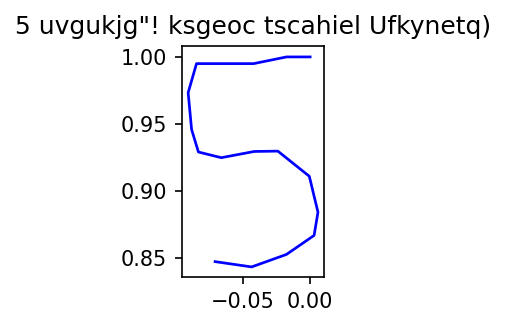

In [ ]:
np.random.seed(2)
x,c,y = test_dataset[10] #7
wt = test_dataset.split_by_word_tokens(x)
print(len(wt))
tokens = wt[0]

offset_samp = test_dataset.decode_stroke(tokens)
point_samp = word_offsets_to_points(offset_samp)
decoded_ascii = test_dataset.decode_text(c)
_ = plot_strokes(point_samp, decoded_ascii)
print(len(point_samp))
print(decoded_ascii)
print(tokens)

In [ ]:
# def generate_helper_fn(model, dataset, text, num_steps=1250, do_sample=False,
#                          top_k=None, temperature=1.0, n_words=4, seed_ix=0, verbose=False):
#     '''Assumes we're using tokenization of git commit afc2425f5bf92c14a9db62da44e8cf2995e7bf8d'''
#     SEED_TOKENS = [torch.tensor(
#         [341,   0, 232,  13, 445,  13, 232,  13, 432,  12, 390,  13, 391,
#         13, 350,   9, 335,  13, 347,  13, 372,  13, 396,  13, 424,  12,
#        439,  13, 232,  16, 341, 116, 454, 454], dtype=torch.int64),
#         torch.tensor(
#         [341,   0, 232,  11, 444,  12, 232,  11, 417,  14, 397,  13, 392,
#         13, 331,  16, 341,  11, 368,  13, 393,  18, 421,  12, 438,  12,
#        232,  15, 341, 116, 454, 454], dtype=torch.int64)][seed_ix]
#     SEED_CHARS = '5'

#     model_device = next(model.parameters()).device
#     warmup_steps = len(SEED_TOKENS)

#     def trunc_or_pad_words(text):
#       n = len(text.split(' '))
#       if n > n_words:
#         if verbose: print(f"Expected {n_words+1} words, got {n}; truncating")
#         return ' '.join(text.split(' ')[:n_words])
#       elif n < n_words:
#         if verbose: print(f"Expected {n_words+1} words, got {n}; padding with 'hello'")
#         return text + ' hello'*(n_words-n)
#       return text
#     text = trunc_or_pad_words(text)
#     ascii_context = f'{SEED_CHARS} {text}'

#     context = dataset.encode_text(ascii_context).unsqueeze(0)
#     context = context.to(model_device)
#     X_init = SEED_TOKENS.unsqueeze(0).to(model_device)

#     steps = num_steps - X_init.size(1)
#     X_samp = generate(model, X_init, context, steps, temperature=temperature,
#                       top_k=top_k, do_sample=do_sample).to('cpu')

#     stroke_seq = X_samp[0].detach().cpu().numpy()[len(SEED_TOKENS):]
#     offset_samp = dataset.decode_stroke(stroke_seq)
#     point_samp = word_offsets_to_points(offset_samp)

#     return offset_samp, point_samp

In [ ]:
# text = 'Hello Zachary Wimpee'
# offset_samp, point_samp = generate_helper_fn(model, test_dataset, text=text)
# fig, ax = plot_strokes(point_samp, f'Target text: "{text}"')

In [ ]:
text = """Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans. Many a brave soul did it send hurrying down to Hades, and many a hero did it yield a prey to dogs and vultures, for so were the counsels of Jove fulfilled"""
word_list_offsets = generate_paragraph(model, test_dataset, text, n_at_a_time=3, do_sample=False,
                                       top_k=None, temperature=1.0, num_steps=1250,
                                       n_words=4, seed_ix=0)

Generating...
    Sing, O goddess,
    the anger of
    Achilles son of
    Peleus, that brought
    countless ills upon
    the Achaeans. Many
    a brave soul
    did it send
    hurrying down to
    Hades, and many
    a hero did
    it yield a
    prey to dogs
    and vultures, for
    so were the
    counsels of Jove
    fulfilled


In [ ]:
len(word_list_offsets), len(text.split(' '))

(49, 49)

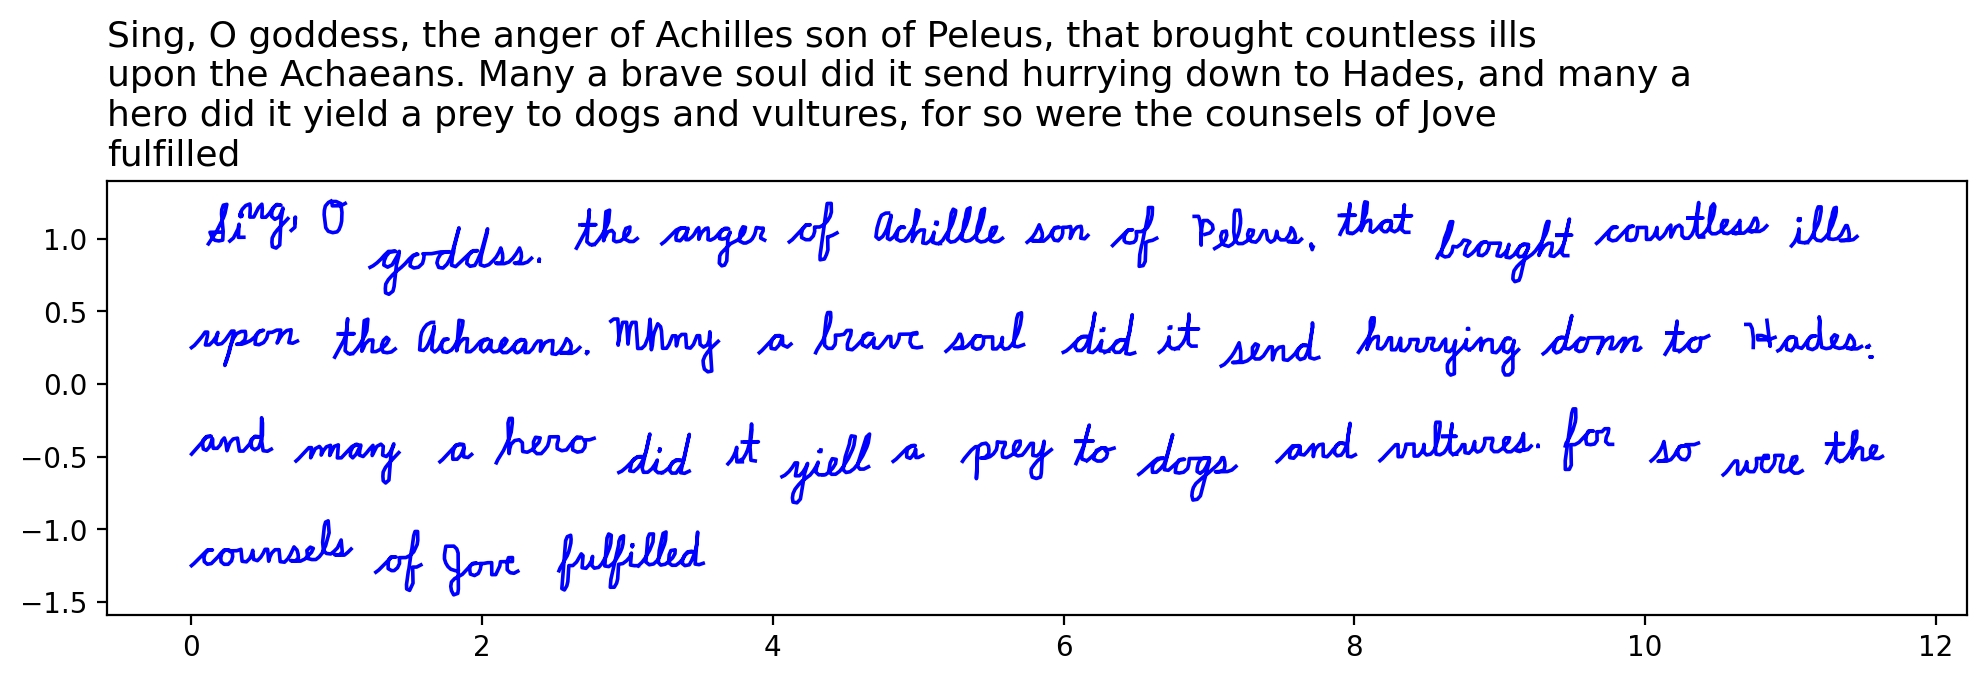

In [ ]:
import textwrap

def plot_paragraph(word_list_offsets, text, figsize=(12, 4*2), dpi=200, **kwargs):
    point_samp = word_offsets_to_points(word_list_offsets, **kwargs)
    fig, ax = plot_strokes(point_samp, '', figsize=figsize, dpi=dpi)
    ax.set_title('\n'.join(textwrap.wrap(text, width=83)), loc='left', fontsize=13)

plot_paragraph(word_list_offsets, text, line_width=12.0)

# OLD STUFF

In [ ]:
def generate_paragraph(model, dataset, word_list, n_at_a_time=3, **kwargs):
  word_list_offsets = []
  print('Generating...')
  for i in range(0, len(word_list), n_at_a_time):
      words_to_generate = word_list[i:i+n_at_a_time]
      text = ' '.join(words_to_generate)
      offset_samp, _ = generate_helper_fn(model, dataset, text=text, **kwargs)
      word_list_offsets += offset_samp[:len(words_to_generate)]
      print('   ', text)
  return word_list_offsets

In [ ]:
text = """Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans. Many a brave soul did it send hurrying down to Hades, and many a hero did it yield a prey to dogs and vultures, for so were the counsels of Jove fulfilled"""
word_list = text.split(' ')

word_list_offsets = generate_paragraph(model, test_dataset, word_list, n_at_a_time=3, do_sample=False,
                                       top_k=None, temperature=1.0, num_steps=1250,
                                       n_words=4, seed_ix=0)

Generating...
    Sing, O goddess,
    the anger of
    Achilles son of
    Peleus, that brought
    countless ills upon
    the Achaeans. Many
    a brave soul
    did it send
    hurrying down to
    Hades, and many
    a hero did
    it yield a
    prey to dogs
    and vultures, for
    so were the
    counsels of Jove
    fulfilled


In [ ]:
def word_offsets_to_points(word_offsets, space_width=0.17, line_width=6.0, line_height=0.75,
                          min_x=0, max_y=5.0):  # Add bounds parameters
    word_points = []
    last_point = None
    current_x = current_y = 0

    for offsets in word_offsets:
        points = offsets_to_strokes(offsets)
        if last_point is not None:
            points = points + last_point[np.newaxis, :]
            # Check if word exceeds line width and wrap if needed
            if len(points) > 0 and current_x + (points[-1][0] - points[0][0]) > line_width:
                current_x = min_x  # Reset to minimum x bound
                current_y = min(current_y + line_height, max_y)  # Bound maximum y
                points = points + np.array([current_x - points[0][0], current_y - points[0][1], 0])

        if len(points) > 0:
            # Update last point and add space for next word
            last_point = points[-1].copy()
            last_point[0] = (current_x := max(min_x, min(last_point[0] + space_width, line_width)))
            last_point[1] = min(current_y, max_y)

        word_points.append(points)

    return np.vstack(word_points)

def plot_strokes(stroke, title, fig=None, ax=None, figsize=(12, 2), dpi=150):
    """Plot a single stroke"""
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Separate strokes based on pen lifts
    strokes = []
    current_stroke = []
    for point in stroke:
        if point[2] == 1:  # Pen is down
            current_stroke.append(point)
        else:  # Pen is up
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
    if current_stroke:
        strokes.append(current_stroke)

    # Plot each stroke
    for stroke in strokes:
        x, y = zip(*[(p[0], 1 - p[1]) for p in stroke])  # Invert y-axis
        ax.plot(x, y, 'b-', linewidth=1.3)

    ax.set_aspect('equal') ; ax.set_title(title)
    if fig is None: plt.show()
    return fig, ax

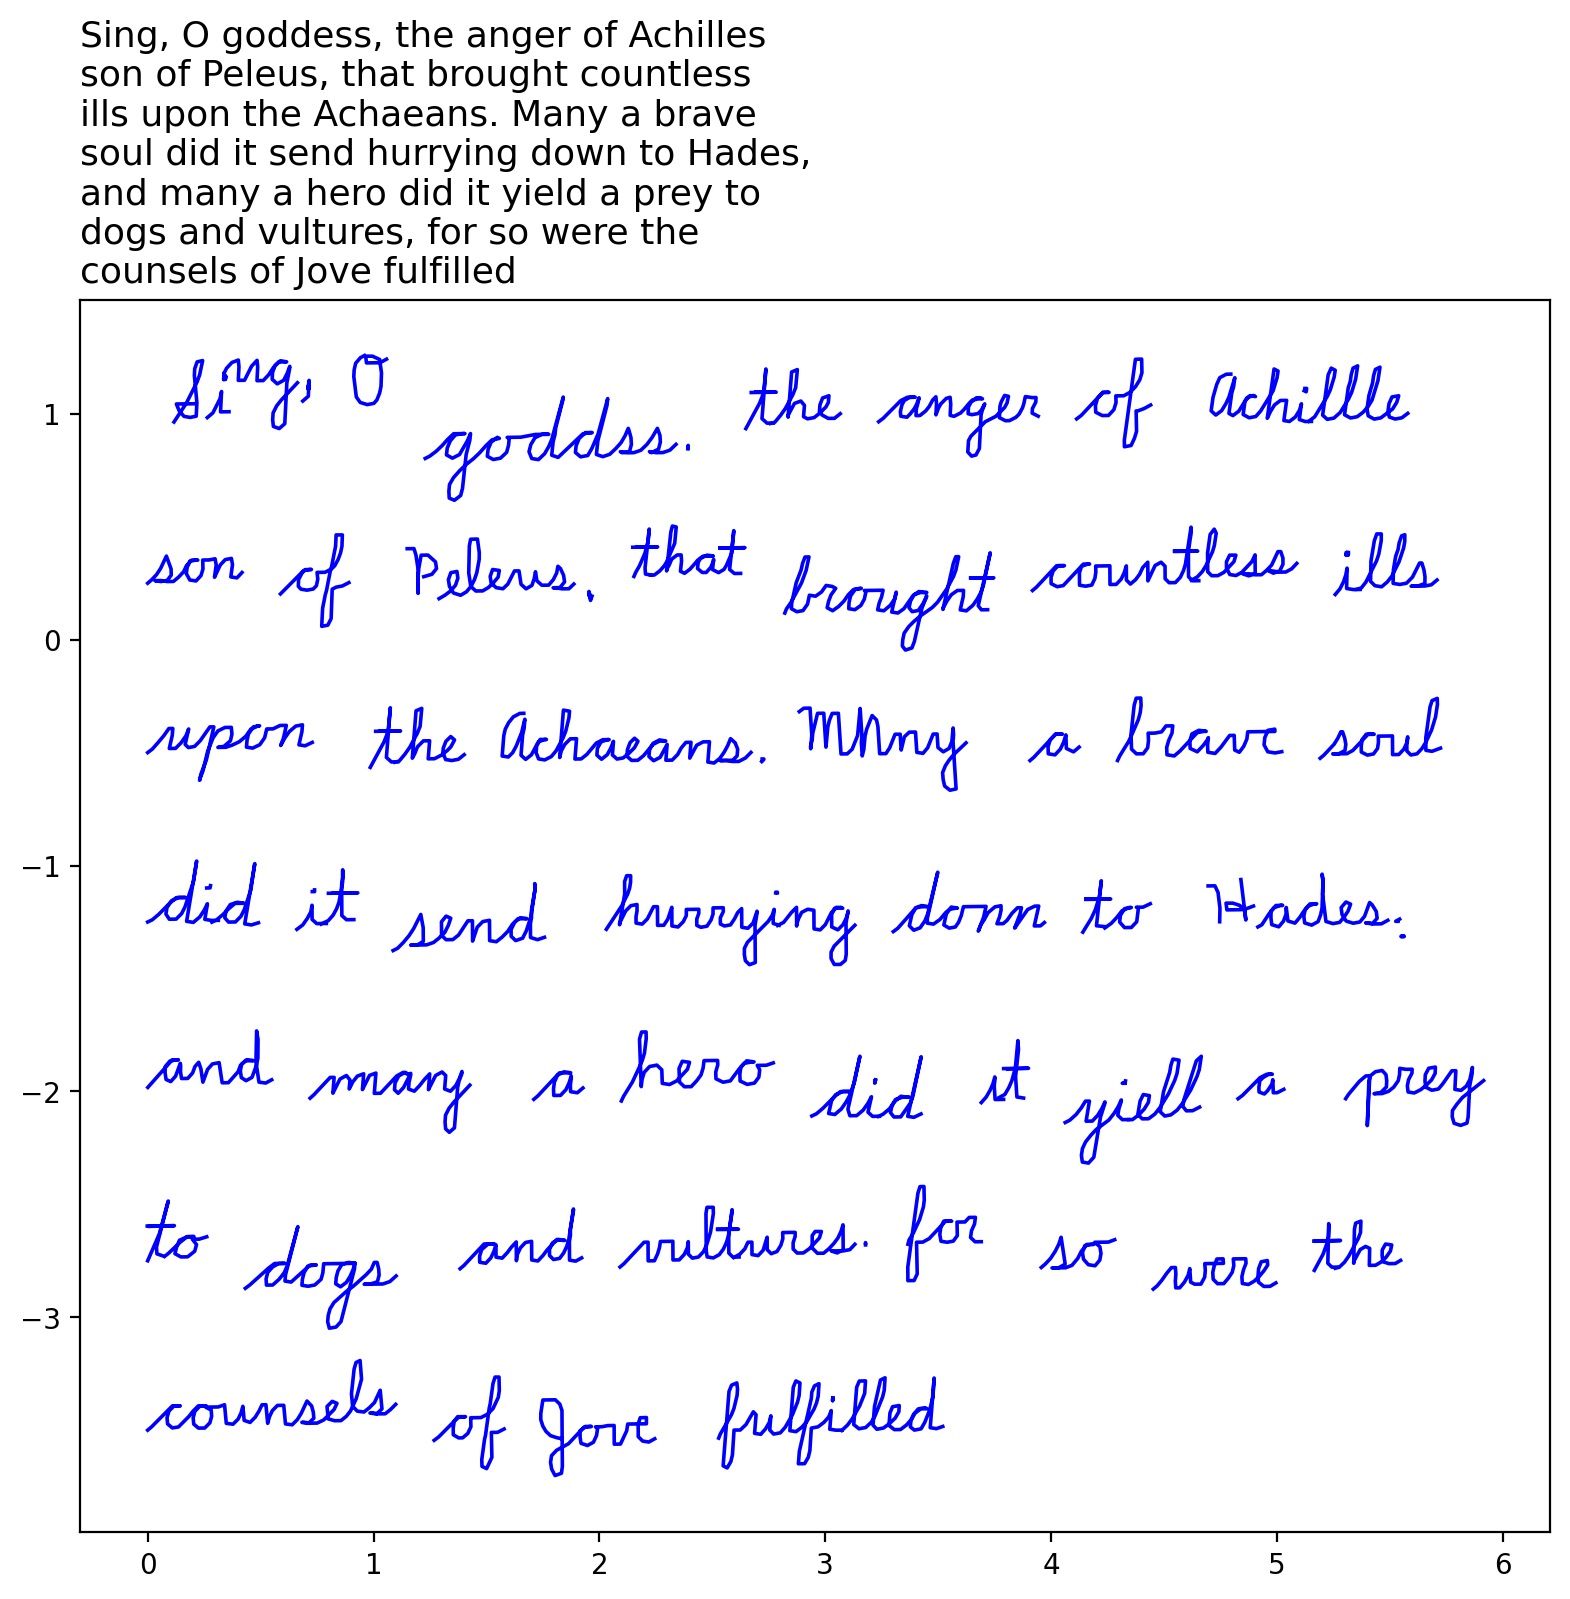

In [ ]:
import textwrap

def plot_paragraph(word_list_offsets, word_list):
  point_samp = word_offsets_to_points(word_list_offsets)
  fig, ax = plot_strokes(point_samp, '', figsize=(12, 4*2), dpi=200)
  ax.set_title('\n'.join(textwrap.wrap(' '.join(word_list), width=40)), loc='left', fontsize=13)

plot_paragraph(word_list_offsets, word_list)

In [ ]:
def generate_word_offsets(model, dataset, word_list, model_device='cpu', do_sample=False,
                         top_k=None, temperature=1.0, num_steps=1250, n_words=4, seed_ix=0):


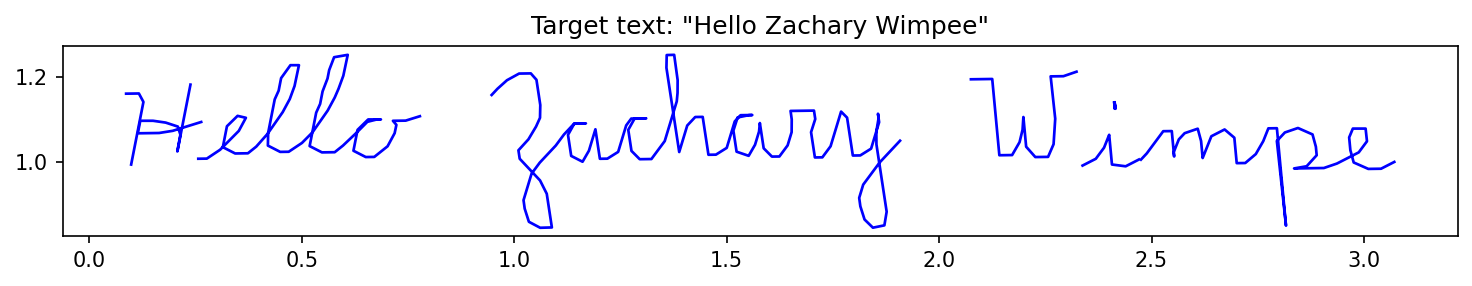

In [ ]:
text = 'Hello Zachary Wimpee'
offset_samp, point_samp = generate_helper_fn(model, test_dataset, text=text)
point_samp = word_offsets_to_points(offset_samp[:3])
fig, ax = plot_strokes(point_samp, f'Target text: "{text}"')

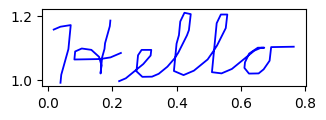

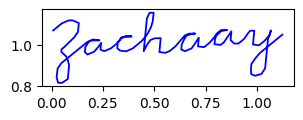

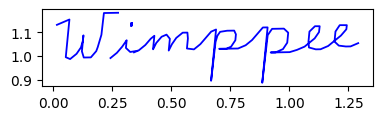

In [ ]:
def split_into_strokes(point_off):
    word_breaks = np.where((point_off[:,0] > 0.15))[0]
    word_breaks = word_breaks[np.diff(np.concatenate(([0], word_breaks))) > 1]
    word_breaks = wb = np.concatenate(([0], word_breaks + 1, [-1]))
    return [point_off[wb[i]:wb[i+1]] for i in range(len(wb)-1)]

words_ = split_into_strokes(point_off)
words = [np.concatenate([words_[0], words_[1]], axis=0),
         words_[2],
         np.concatenate([words_[3], words_[4]], axis=0)]

fig, ax = plot_strokes(offsets_to_strokes(words[0]), '', *plt.subplots(figsize=(6, 1), dpi=100))
fig, ax = plot_strokes(offsets_to_strokes(words[1]), '', *plt.subplots(figsize=(6, 1), dpi=100))
fig, ax = plot_strokes(offsets_to_strokes(words[2]), '', *plt.subplots(figsize=(6, 1), dpi=100))

In [ ]:
def save_samples(model, dataset, model_device='cpu', warmup_steps=100, do_sample=False, log_wandb=True):
    """ samples from the model and plots the decoded strokes """
    model_device = next(model.parameters()).device

    np.random.seed(2)
    x,c,y = dataset[14]
    warmup_steps = 100

    decoded_ascii = dataset.decode_text(c)
    decoded_ascii = decoded_ascii[:11] + ' Hello world!'
    c_ = dataset.encode_text(decoded_ascii)
    print(c, '\n', c_)
    print(decoded_ascii)
    stroke_seq = [x] ; context = [c_]

    X_init = torch.stack(stroke_seq).to(model_device)[:,:warmup_steps]
    context = torch.stack(context).long().to(model_device)
    top_k = None
    steps = dataset.get_stroke_seq_length() - 1  # -1 because we already start with the first token

    X_samp = generate(model, X_init, context, steps, top_k=top_k, do_sample=do_sample).to('cpu')

    for i in range(X_samp.size(0)):
        # get the i'th row of sampled integers, as python list
        row = X_samp[i].detach().cpu().numpy()
        offset_samp = dataset.decode_stroke(row)
        point_samp = offsets_to_strokes(offset_samp)
        decoded_ascii = dataset.decode_text(context[i])

        # Plot the stroke
        fig, ax = plot_strokes(point_samp, f'Sample {i+1}: "{decoded_ascii}"') #plt.axis('off')
        tag = 'sample' if do_sample else 'topk'
        fig.savefig(f"{dataset.name}_{tag}_{i+1}.png")
        if log_wandb:
            wandb.log({f"{dataset.name}_{tag}_{i+1}": wandb.Image(f"{dataset.name}_{tag}_{i+1}.png")})
        plt.close(fig)
        print(f"Saved {dataset.name}_{tag}_{i+1}.png")

    print('-'*80)

save_samples(model, test_dataset, do_sample=False, log_wandb=False)

tensor([ 8,  3,  3,  1, 40, 28, 16, 21,  4, 25,  4,  1, 44, 66, 44,  1, 13, 36,
        35, 34, 36, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 
 tensor([ 8,  3,  3,  1, 40, 28, 16, 21,  4, 25,  4,  1, 47,  2, 27, 27,  7,  1,
        25,  7, 10, 27, 11, 63,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
snn Tqucawa Hello world!
Saved test_topk_1.png
--------------------------------------------------------------------------------


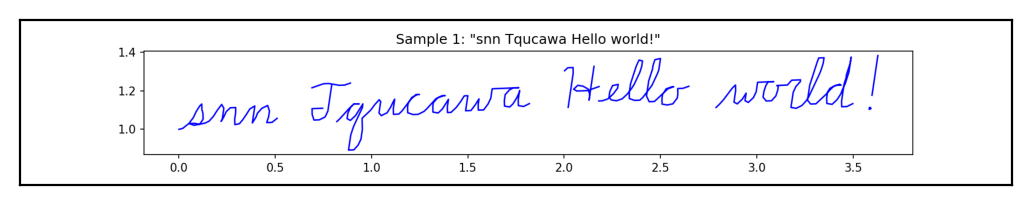

In [ ]:
img = Image.open('test_topk_1.png')
fig, ax = plt.subplots(dpi=200)
ax.imshow(img)
ax.set_xticks([]) ; ax.set_yticks([]) ; plt.show()

In [ ]:
SEED_TOKENS = torch.tensor([377,   0, 371,  21, 361,  41, 355,  38, 350,  34, 353,  36, 359,  15,
        414,  30, 408,  21, 414,  30, 429,  31, 447,  30, 310,  28, 376,  28,
        381,  28, 372,  30, 366,  23, 357,  34, 353,  36, 355,  39, 402,  23,
        418,  30, 418,  30, 428,  12, 353,  24, 350,  34, 359,  30, 376,  28,
        415,  30, 418,  30, 414,  30, 372,  25, 356,  27, 354,  31, 353,  36,
        364,  31, 418,  30, 418,  30, 418,  30, 353,  36, 348,  22, 357,  34,
        366,  34, 407,  31, 418,  30, 422,  32, 376,  28, 361,  34, 377, 151,
        376, 232], dtype=torch.int6x4)
SEED_CHARS = 'snn'
REMAINING_CHARS = 'Sam was here'

In [ ]:
def generate_n_words(model, dataset, ascii, model_device='cpu', do_sample=False,
                         top_k=None, temperature=1.0, num_steps=950, n_words=4):
    SEED_TOKENS = torch.tensor([377,   0, 371,  21, 361,  41, 355,  38, 350,  34, 353,  36, 359,  15,
        414,  30, 408,  21, 414,  30, 429,  31, 447,  30, 310,  28, 376,  28,
        381,  28, 372,  30, 366,  23, 357,  34, 353,  36, 355,  39, 402,  23,
        418,  30, 418,  30, 428,  12, 353,  24, 350,  34, 359,  30, 376,  28,
        415,  30, 418,  30, 414,  30, 372,  25, 356,  27, 354,  31, 353,  36,
        364,  31, 418,  30, 418,  30, 418,  30, 353,  36, 348,  22, 357,  34,
        366,  34, 407,  31, 418,  30, 422,  32, 376,  28, 361,  34, 377, 151,
        376, 232], dtype=torch.int64)
    SEED_CHARS = 'snn'

    model_device = next(model.parameters()).device
    warmup_steps = len(SEED_TOKENS)
    ascii_context = f'{SEED_CHARS} {ascii}'

    def count_words(text):
      return len(text.split(' '))
    assert count_words(ascii_context) == n_words, f"Expected {n_words} words, got {count_words(ascii_context)}"

    context = dataset.encode_text(ascii_context).unsqueeze(0).to(model_device)
    X_init = SEED_TOKENS.unsqueeze(0).to(model_device)

    steps = num_steps - X_init.size(1)
    X_samp = generate(model, X_init, context, steps, temperature=temperature,
                      top_k=top_k, do_sample=do_sample).to('cpu')

    stroke_seq = X_samp[0].detach().cpu().numpy()[len(SEED_TOKENS):]
    offset_samp = dataset.decode_stroke(stroke_seq)
    point_samp = offsets_to_strokes(offset_samp)

    return point_samp, ascii

point_samp, ascii = generate_n_words(model, test_dataset, ascii='Hello Zachary Wimpee!')

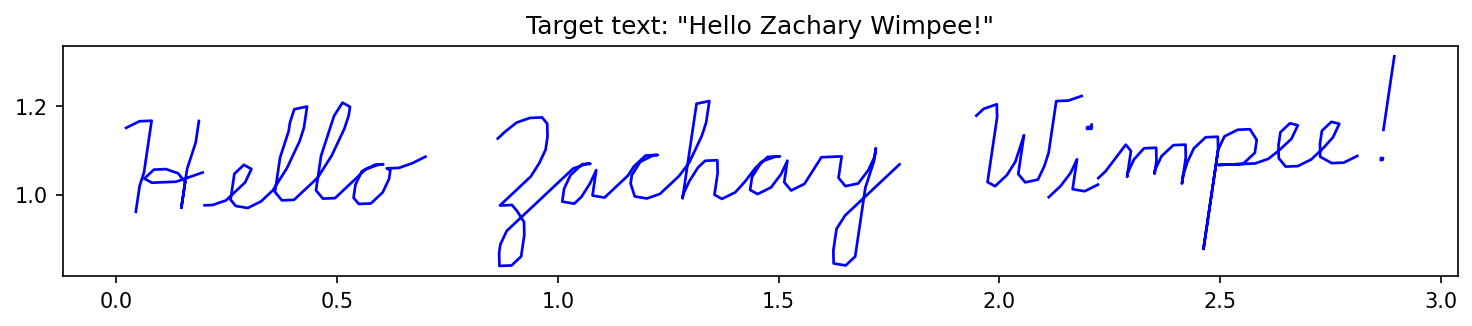

In [ ]:
fig, ax = plot_strokes(point_samp, f'Target text: "{ascii}"')

In [ ]:
# def ascii_to_strokes(model, dataset, ascii, model_device='cpu',
#                      do_sample=False, top_k=None, temperature=1.0, num_steps=950):
#     model_device = next(model.parameters()).device
#     warmup_steps = len(SEED_TOKENS)
#     ascii = f'{SEED_CHARS} {ascii}'
#     context = dataset.encode_text(ascii).unsqueeze(0).to(model_device)

#     X_init = SEED_TOKENS.unsqueeze(0).to(model_device)[:, :warmup_steps]

#     steps = num_steps - X_init.size(1)
#     X_samp = generate(model, X_init, context, steps, temperature=temperature,
#                       top_k=top_k, do_sample=do_sample).to('cpu')

#     stroke_seq = X_samp[0].detach().cpu().numpy()
#     offset_samp = dataset.decode_stroke(stroke_seq)
#     point_samp = offsets_to_strokes(offset_samp)

#     return point_samp, ascii